### Exploratory Data Analysis on processed_dataset_v3 that contains combined data of 
1. IMDB Dataset
2. Netflix Dataset
3. Top 200 Actors
4. Top 200 Directors

In [2]:
# Importing required libraries

from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyspark.sql import HiveContext

In [3]:
# Initiating Spark session
spark = SparkSession.builder.enableHiveSupport().appName('EDA').getOrCreate()
sc = spark.sparkContext

In [4]:
# Intiating Hive contest to pull hive table from hadoop system
hive_context = HiveContext(sc)

In [5]:
data = hive_context.table('aghose.processed_dataset_v3')

In [6]:
data.printSchema()

root
 |-- Movie_Id: integer (nullable = true)
 |-- Cust_Id: integer (nullable = true)
 |-- Rating: double (nullable = true)
 |-- tconst: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- Actor_0: string (nullable = true)
 |-- Actor_1: string (nullable = true)
 |-- Actor_2: string (nullable = true)
 |-- Actor_3: string (nullable = true)
 |-- Actor_4: string (nullable = true)
 |-- Actor_5: string (nullable = true)
 |-- Actor_6: string (nullable = true)
 |-- Actor_7: string (nullable = true)
 |-- Actor_8: string (nullable = true)
 |-- Actor_9: string (nullable = true)
 |-- Director_0: string (nullable = tr

In [7]:
data.groupBy('genres').count().show(100, False)

+----------------------------+-------+
|genres                      |count  |
+----------------------------+-------+
|Comedy,Sport                |587390 |
|Action,Adventure,Fantasy    |851379 |
|Animation,Sci-Fi,War        |115    |
|Adventure,Family,Fantasy    |529538 |
|Fantasy,Mystery,Thriller    |6127   |
|Documentary,Sport           |34953  |
|Film-Noir,Mystery,Thriller  |30684  |
|Comedy,Musical,Sci-Fi       |849    |
|Action,Animation,Sci-Fi     |2426   |
|Comedy,Family               |267782 |
|Animation,Comedy            |308    |
|Action,Comedy               |165985 |
|Drama,Mystery               |120609 |
|Crime                       |212    |
|Adventure,History,Romance   |611    |
|Musical,Romance,Thriller    |78     |
|Biography,Drama,Musical     |40156  |
|Action,Romance,Western      |603    |
|Adventure,Comedy,Drama      |374476 |
|Drama,Music,Musical         |19681  |
|Romance                     |1328   |
|Drama,Romance,Sport         |80652  |
|Comedy,Drama,Mystery    

In [8]:
# Count of all customers
data.select('Cust_Id').distinct().count()

479107

In [9]:
# Count of all Movies
data.select('Movie_Id').distinct().count()

7602

In [10]:
# Movie_Id and Cust_id combined work as a unique id for the whole dataset
data.select('Movie_Id', 'Cust_Id').distinct().count()

79000155

In [11]:
# Total count of rows
data.count()

79000155

#### Genres vs Count
From above we undestand that (Cust_Id, Movie_Id) form a unique identifer for each row.


In [12]:
data.select('genres').distinct().count()

500

In [13]:
pdf = data.groupBy('genres').count().sort(desc('count')).limit(30).toPandas()

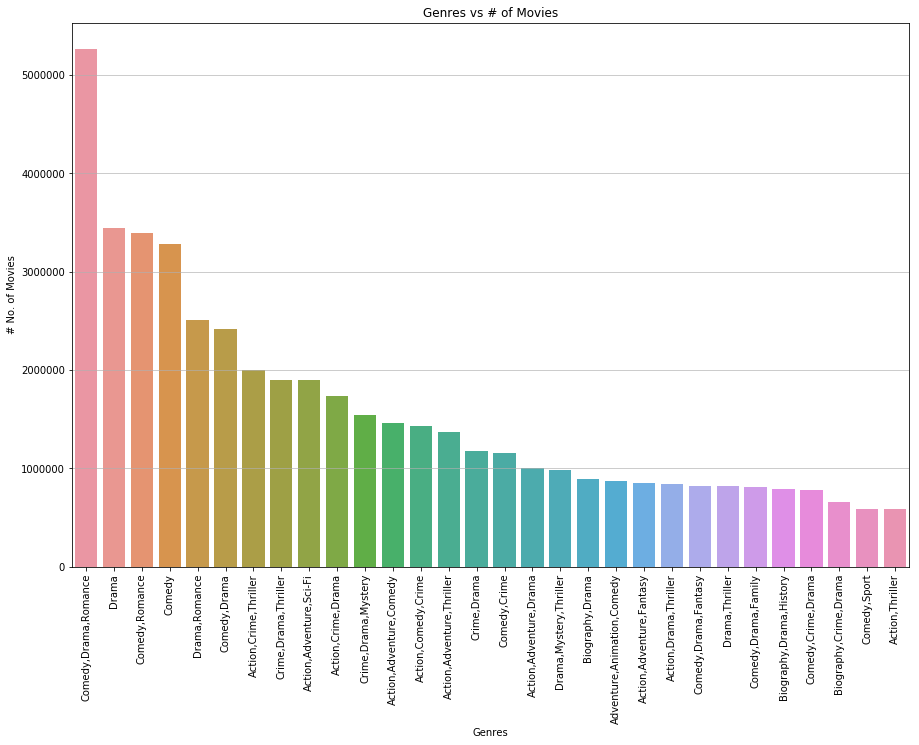

In [14]:
# Plot of genres vs number of movies

plt.figure(figsize = (15,10))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha = 0.8)
g = sns.barplot(y = pdf['count'], x = pdf['genres'])
# plt.xticks(rotation = 90)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Genres vs # of Movies')
plt.ylabel('# No. of Movies')
plt.xlabel('Genres')
plt.show()

In [15]:
pdf.head(10)

,genres,count
0,"Comedy,Drama,Romance",5268372
1,Drama,3446845
2,"Comedy,Romance",3393072
3,Comedy,3285721
4,"Drama,Romance",2507020
5,"Comedy,Drama",2416742
6,"Action,Crime,Thriller",1997281
7,"Crime,Drama,Thriller",1896597
8,"Action,Adventure,Sci-Fi",1894291
9,"Action,Crime,Drama",1731335


#### Genres vs Average Rating
1. Genres vs IMDB Rating
2. Genres vs Netflix Rating

In [16]:
pdf_genre_rating = data.groupBy('genres').agg(round(avg('averageRating'),2).alias('grp_avg_IMDB')).sort(desc('grp_avg_IMDB')).toPandas()
pdf_genre_rating.head()

,genres,grp_avg_IMDB
0,"Animation,Drama,War",8.50
1,"Crime,Drama,Fantasy",8.49
2,"Drama,Mystery,War",8.40
3,"Crime,Drama,Sci-Fi",8.30
4,"Documentary,Drama,Sport",8.24


In [17]:
pdf_genre_rating_net = data.groupBy('genres').agg(round(avg('Rating'),2).alias('grp_avg_Netflix')).sort(desc('grp_avg_Netflix')).toPandas()
pdf_genre_rating_net.head()

,genres,grp_avg_Netflix
0,"Crime,Drama,Fantasy",4.26
1,"Action,Adventure",4.22
2,"Adventure,Drama,War",4.11
3,"Adventure,Mystery,Thriller",4.10
4,"Family,Fantasy,Musical",4.06


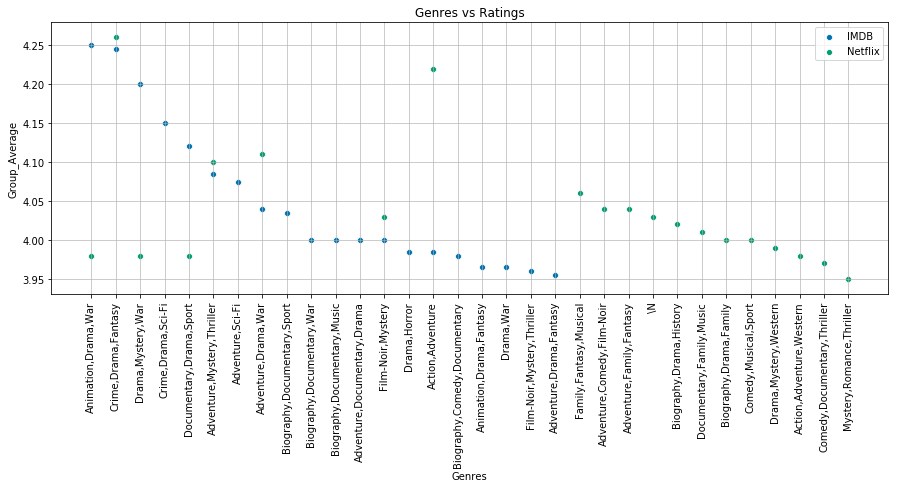

In [18]:
# How generes as tagged in the table compare with ratings

plt.figure(figsize = (15,5))
plt.grid(True, alpha = 0.8)
g = sns.scatterplot(y = pdf_genre_rating['grp_avg_IMDB'][:20]/2, x = pdf_genre_rating['genres'][:20].values, markers='o', label = 'IMDB')
g = sns.scatterplot(y = pdf_genre_rating_net['grp_avg_Netflix'][:20], x = pdf_genre_rating_net['genres'][:20].values, markers='+',label = 'Netflix')
plt.xticks(rotation = 90)
plt.title('Genres vs Ratings')
plt.xlabel('Genres')
plt.ylabel('Group_Average')
plt.show()


#### # of Movies vs Year

In [19]:
# Creating dataframe to plot years vs # of movies
pdf_movies_per_year = data.groupBy('Year').agg(count('Movie_Id').alias('num_movies')).sort(desc('num_movies')).toPandas()
pdf_movies_per_year.head()

,Year,num_movies
0,2004,8711712
1,2003,7257720
2,2002,6527120
3,2000,5292369
4,2001,5136720


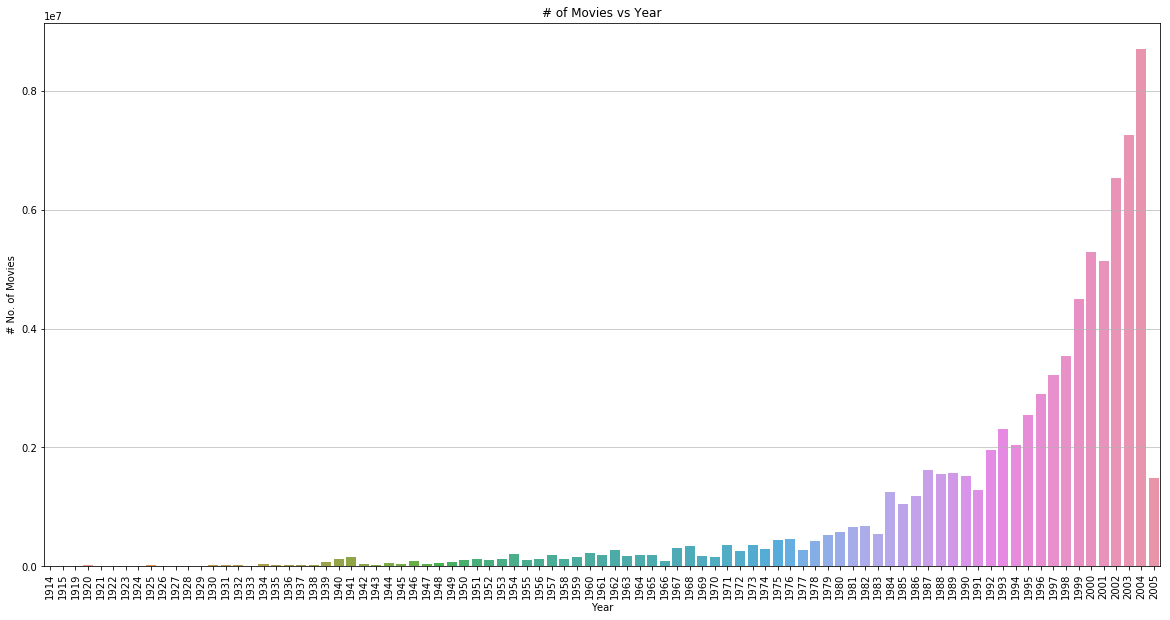

In [20]:
# Plot view the rate at which movies are produced over the years
plt.figure(figsize = (20,10))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha = 0.8)
g = sns.barplot(y = pdf_movies_per_year['num_movies'], x = pdf_movies_per_year['Year'])
# plt.xticks(rotation = 90)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('# of Movies vs Year')
plt.ylabel('# No. of Movies')
plt.xlabel('Year')
plt.show()

Note: Data is available till 2005

#### Movies vs Average Rating

In [21]:
# Since we need to find the average of averageRatings and we don't have the original data, we are using median to get the 
# most highest ratings given to movies
magic_percentile = F.expr('percentile_approx(averageRating, 0.5)')

In [22]:
pdf_movies_vs_averagerating = data.groupBy('Name').agg(magic_percentile.alias('med_val'), avg('runtimeMinutes').alias('runtime')).sort(desc('med_val')).toPandas()

In [23]:
pdf_movies_vs_averagerating.head()

,Name,med_val,runtime
0,The Godfather,9.2,175.0
1,Pulp Fiction,8.9,154.0
2,The Message,8.9,207.0
3,Schindler's List,8.9,195.0
4,12 Angry Men,8.9,96.0


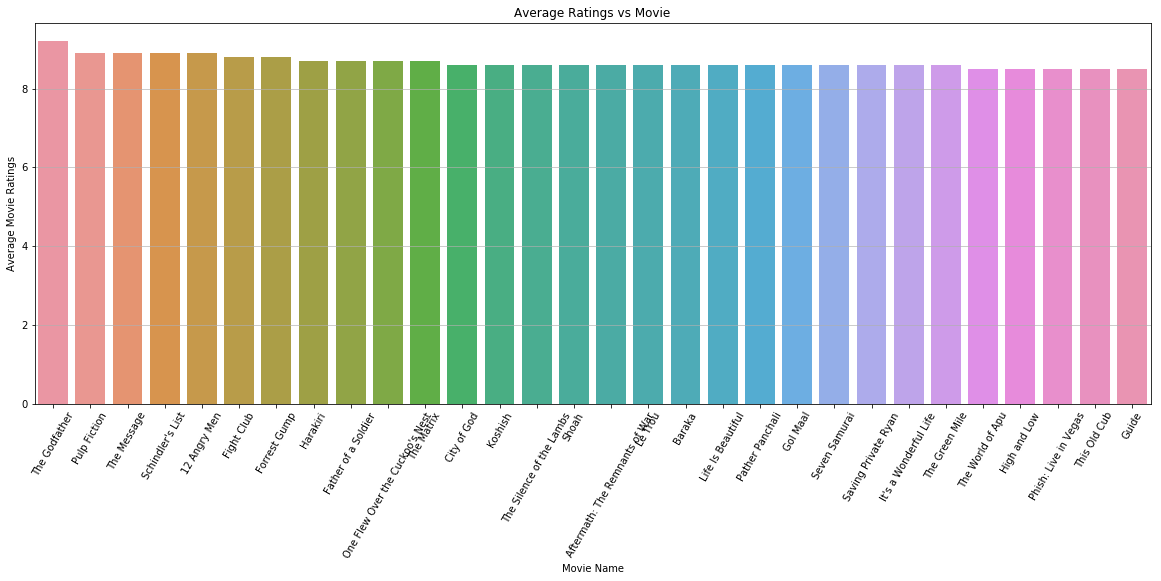

In [24]:
# Plot average ratings with top movies
plt.figure(figsize = (20,7))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha = 0.8)
g = sns.barplot(y = pdf_movies_vs_averagerating['med_val'][:30], x = pdf_movies_vs_averagerating['Name'][:30])
# plt.xticks(rotation = 90)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title('Average Ratings vs Movie')
plt.ylabel('Average Movie Ratings')
plt.xlabel('Movie Name')
plt.show()

#### Ratings vs Runtime

In [25]:
pdf_movies_vs_averagerating.head()

,Name,med_val,runtime
0,The Godfather,9.2,175.0
1,Pulp Fiction,8.9,154.0
2,The Message,8.9,207.0
3,Schindler's List,8.9,195.0
4,12 Angry Men,8.9,96.0


In [26]:
# Binning movie runtime into 4 categories
import pandas as pd
bins = [0, 120, 150, 180, 300]
pdf_movies_vs_averagerating['binned'] = pd.cut(pdf_movies_vs_averagerating['runtime'], bins)
pdf_movies_vs_averagerating.head()

,Name,med_val,runtime,binned
0,The Godfather,9.2,175.0,"(150, 180]"
1,Pulp Fiction,8.9,154.0,"(150, 180]"
2,The Message,8.9,207.0,"(180, 300]"
3,Schindler's List,8.9,195.0,"(180, 300]"
4,12 Angry Men,8.9,96.0,"(0, 120]"


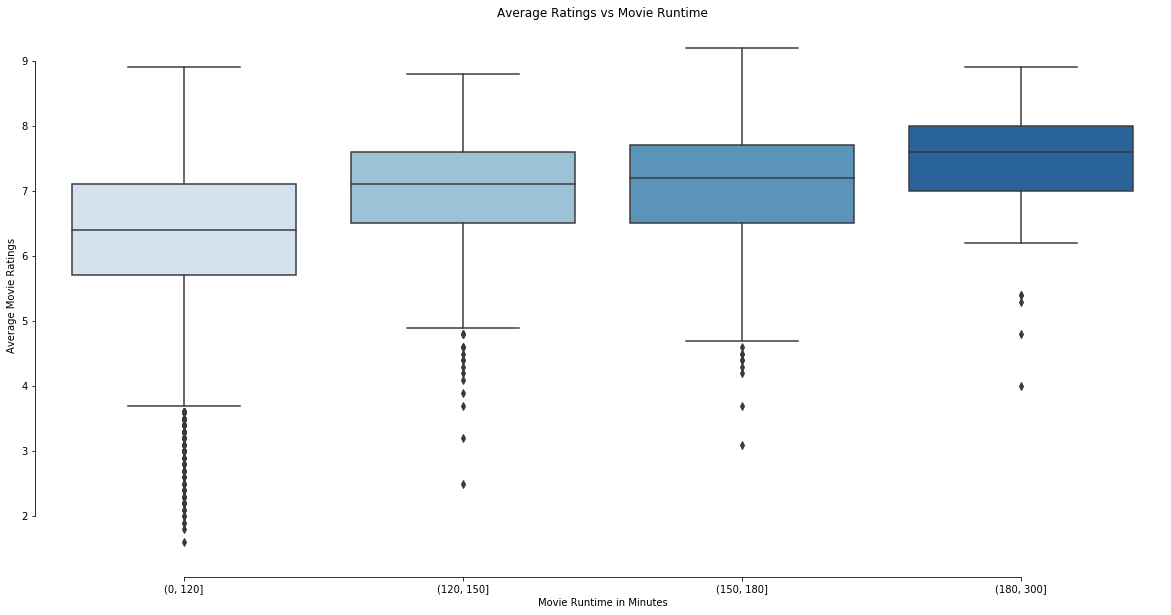

In [27]:
# Boxplot to see how ratings change with increase in movie runtime in mins
plt.figure(figsize = (20,10))
g = sns.boxplot(x=pdf_movies_vs_averagerating['binned'], y=pdf_movies_vs_averagerating['med_val'], palette = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=0)
plt.title('Average Ratings vs Movie Runtime')
plt.ylabel('Average Movie Ratings')
plt.xlabel('Movie Runtime in Minutes')
sns.despine(offset=10, trim=True)
plt.show()

#### Top 200 directors - # movies - ratings

In [28]:
# List of top 200 actors and directors
top_actors = spark.read.csv("/user/aghose/data/Top_Actors.csv", inferSchema=True, header=True).toPandas()
top_dirs = spark.read.csv("/user/aghose/data/Top_Directors.csv", inferSchema=True, header=True).toPandas()

In [29]:
len(top_actors)

162

In [30]:
top_dirs.head()

,DIRECTORS
0,David Lynch
1,Stanley Kubrick
2,Robert Bresson
3,Alfred Hitchcock
4,Martin Scorsese


In [31]:
# All Director columns for each movie
dir_cols = ['Director_0',
 'Director_1',
 'Director_2',
 'Director_3',
 'Director_4',
 'Director_5']

In [32]:
df_dir = data.select('Director_0','Name','averageRating').filter(col('Director_0').isin(['Abhi'])).limit(1)

In [33]:
df_dir.show()

+----------+----+-------------+
|Director_0|Name|averageRating|
+----------+----+-------------+
+----------+----+-------------+



In [34]:
# Looping through all director columns to match with Top 200 Directors list
for col_dir in dir_cols:
    df_row = data.select(col_dir,'Name','averageRating').filter(col(col_dir).isin(list(top_dirs.DIRECTORS)))
    df_dir = df_dir.union(df_row)

In [35]:
df_dir.count()

12987733

In [36]:
# Grouping count of movies and median rating by top directors
pdf_dir_ratings = df_dir.groupBy('Director_0').agg(countDistinct('Name').alias('#_movies'), avg('averageRating').alias('Rating')).sort(desc('Rating')).toPandas()

In [37]:
pdf_dir_ratings.head()

,Director_0,#_movies,Rating
0,Frank Darabont,2,8.436957
1,Akira Kurosawa,14,8.308817
2,Milos Forman,8,8.290687
3,Quentin Tarantino,6,8.268597
4,Sergio Leone,4,8.236910


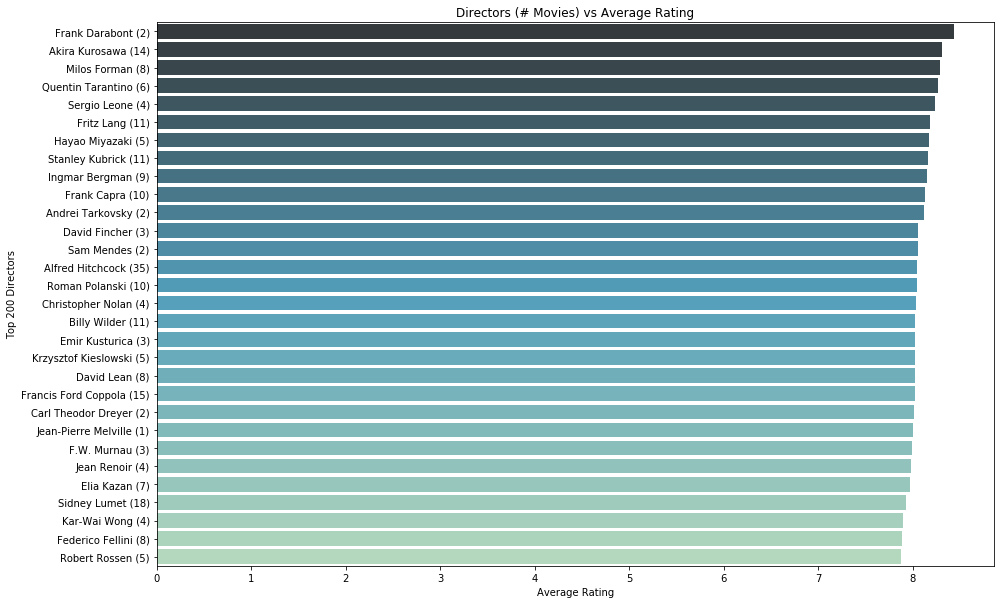

In [38]:
# Show 30 of the top 200 directors sorted by their ratings
plt.figure(figsize = (15,10))
sns.barplot(x=pdf_dir_ratings['Rating'][:30] , y=pdf_dir_ratings['Director_0'][:30]+' ('+ pdf_dir_ratings['#_movies'][:30].map(str)+')', palette="GnBu_d")
plt.xlabel('Average Rating')
plt.ylabel('Top 200 Directors')
plt.title('Directors (# Movies) vs Average Rating')
plt.show()

#### Top 200 actors - # movies - ratings

In [39]:
# List of all actor columns for each movie
actors_cols =['Actor_0',
 'Actor_1',
 'Actor_2',
 'Actor_3',
 'Actor_4',
 'Actor_5',
 'Actor_6',
 'Actor_7',
 'Actor_8',
 'Actor_9']

In [40]:
# Creating an empty dataframe to use in the loop
df_actor = data.select('Actor_0','Name','averageRating').filter(col('Actor_0').isin(['Abhi'])).limit(1)
df_actor.show()

+-------+----+-------------+
|Actor_0|Name|averageRating|
+-------+----+-------------+
+-------+----+-------------+



In [41]:
# Looping through all actor columns to lookup with top 200 actors
for col_actor in actors_cols:
    df_row = data.select(col_actor,'Name','averageRating').filter(col(col_actor).isin(list(top_actors.ACTORS)))
    df_actor = df_actor.union(df_row)

In [42]:
pdf_actor_ratings = df_actor.groupBy('Actor_0').agg(countDistinct('Name').alias('#_movies'), avg('averageRating').alias('Rating')).sort(desc('Rating')).toPandas()

In [43]:
pdf_actor_ratings.head()

,Actor_0,#_movies,Rating
0,Andy Griffith,1,8.200000
1,Donna Reed,5,8.133145
2,Orson Welles,4,8.120670
3,Grace Kelly,6,8.066899
4,James Stewart,31,8.045565


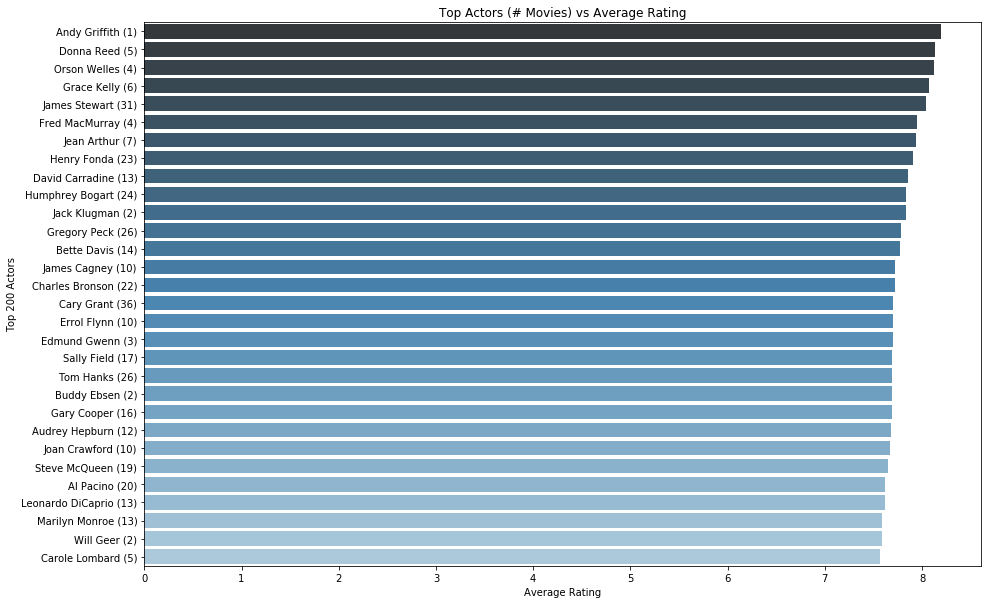

In [44]:
# Plot top 30 actors out of top 200 with average rating
plt.figure(figsize = (15,10))
# sns.set(style="whitegrid")
sns.barplot(x=pdf_actor_ratings['Rating'][:30] , y=pdf_actor_ratings['Actor_0'][:30]+' ('+ pdf_actor_ratings['#_movies'][:30].map(str)+')', palette="Blues_d")

plt.xlabel('Average Rating')
plt.ylabel('Top 200 Actors')
plt.title('Top Actors (# Movies) vs Average Rating')
plt.show()

#### End of visualization